In [7]:
from sklearn.datasets import make_circles

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

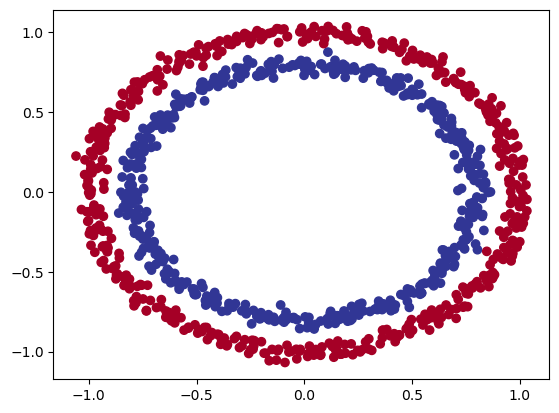

In [4]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [27]:
import torch
Xt = torch.from_numpy(X).type(torch.float) 
yt = torch.from_numpy(y).type(torch.float) 
print(Xt.shape)
print(yt.shape)

torch.Size([1000, 2])
torch.Size([1000])


In [28]:
from sklearn.model_selection import train_test_split

Xtrain,Xtest,ytrain,ytest = train_test_split(Xt,yt, test_size=0.2, random_state=42)

In [29]:
print(Xtrain.shape,Xtest.shape,ytrain.shape,ytest.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


In [11]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [127]:
# Replicate CircleModelV0 with nn.Sequential
torch.manual_seed(42)
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=3,dtype=torch.float),
    nn.ReLU(),
    nn.Linear(in_features=3, out_features=1,dtype = torch.float)
).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params= model_0.parameters(),lr = 0.1)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [128]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = Xtrain.to(device), ytrain.to(device)
X_test, y_test = Xtest.to(device), ytest.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(y_logits) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69753, Accuracy: 50.00% | Test loss: 0.69871, Test acc: 51.50%
Epoch: 10 | Loss: 0.66621, Accuracy: 48.88% | Test loss: 0.65357, Test acc: 61.00%
Epoch: 20 | Loss: 0.58408, Accuracy: 47.00% | Test loss: 0.56607, Test acc: 80.50%
Epoch: 30 | Loss: 0.44858, Accuracy: 37.75% | Test loss: 0.44807, Test acc: 81.00%
Epoch: 40 | Loss: 0.31887, Accuracy: 28.62% | Test loss: 0.35218, Test acc: 86.50%
Epoch: 50 | Loss: 0.22207, Accuracy: 21.25% | Test loss: 0.26771, Test acc: 93.00%
Epoch: 60 | Loss: 0.14937, Accuracy: 13.25% | Test loss: 0.18632, Test acc: 97.00%
Epoch: 70 | Loss: 0.10180, Accuracy: 9.12% | Test loss: 0.14416, Test acc: 95.50%
Epoch: 80 | Loss: 0.07963, Accuracy: 4.62% | Test loss: 0.12227, Test acc: 97.00%
Epoch: 90 | Loss: 0.06761, Accuracy: 4.50% | Test loss: 0.10518, Test acc: 96.00%


helper_functions.py already exists, skipping download


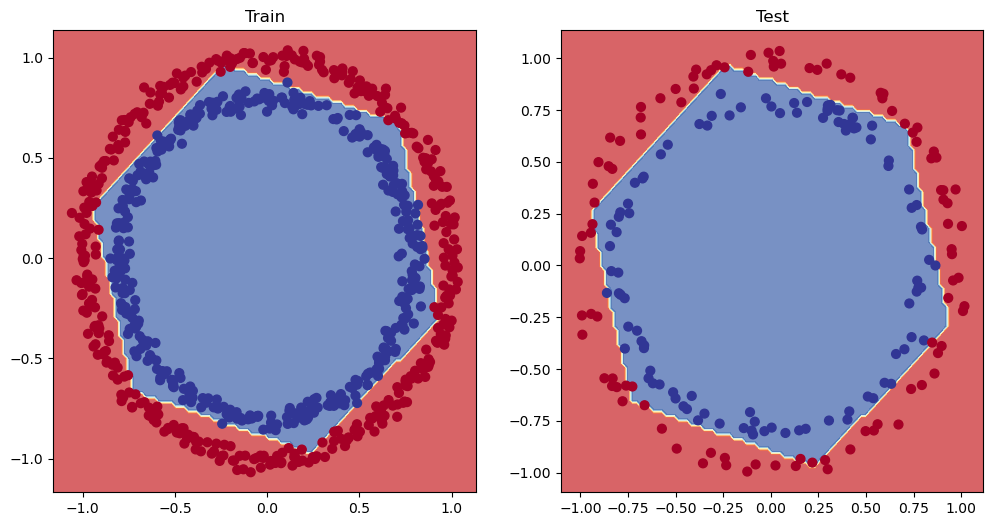

In [129]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

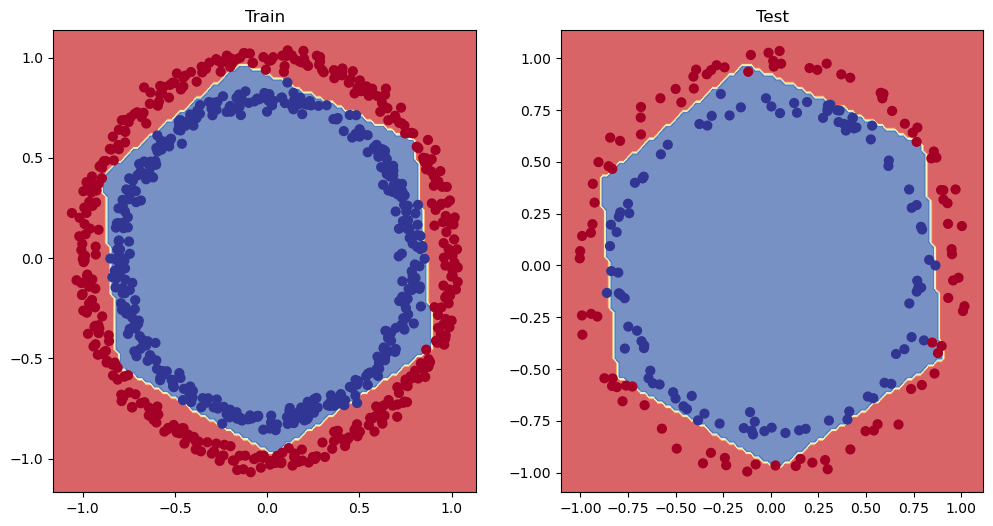